In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from IPython.core.debugger import set_trace

# Import packages

In [2]:
from __future__ import print_function
import os
import shutil
import sys
import inspect
import time
from datetime import datetime
import warnings, logging
import argparse
from easydict import EasyDict as edict
# 
import pickle
# 
import numpy as np
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
# from torchsummary import summary
import torchmodel_summary
import GPUtils
# Metrics
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Visualization-Plot
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import seaborn as sns

# Configs.py

In [3]:
todaystr = datetime.today().strftime('%Y%m%d')       
config = edict()
# MODEl related
config.MODEL = edict()
config.MODEL.NAME = 'DNN_model'
config.MODEL.INIT_WEIGHTS = True
config.MODEL.PRETRAINED = ''
config.MODEL.IMAGE_SIZE = [256, 256]  # width * height, ex: 192 * 256
config.MODEL.STYLE = 'pytorch'
# DIRECTORY related
config.PATH = edict()
config.PATH.ROOT = 'dnn_project'
config.PATH.DATASET = os.path.join(config.PATH.ROOT, 'dataset')
config.PATH.MODELS = os.path.join(config.PATH.ROOT, 'models')
config.PATH.LOGS = os.path.join(config.PATH.ROOT, 'logs')
config.PATH.OUTPUTS = os.path.join(config.PATH.ROOT, 'outputs')
config.PATH.HISTORY_FILE = os.path.join(config.PATH.LOGS, config.MODEL.NAME + '-hist.pckl')
config.PATH.LATEST_MODEL_FILE = os.path.join(config.PATH.LOGS, config.MODEL.NAME + '-checkpoint-latest.pth.tar')
config.PATH.BEST_MODEL_FILE = os.path.join(config.PATH.LOGS, config.MODEL.NAME + '-checkpoint-best.pth.tar')
# HARDWARE related
config.HARDWARE = edict()
config.HARDWARE.USE_GPU = True if torch.cuda.is_available else False
config.HARDWARE.GPU_NAME = ''
if config.HARDWARE.USE_GPU:
    config.HARDWARE.DEVICE = 'cuda'
    config.HARDWARE.NB_GPUS = torch.cuda.device_count()    
    config.HARDWARE.GPU_NAME = [torch.cuda.get_device_name(i) for i in range(config.HARDWARE.NB_GPUS)]
else:
    config.HARDWARE.DEVICE = 'cpu'
    
config.HARDWARE.NUM_WORKERS = 1
# DATASET related
config.DATASET = edict()
config.DATASET.ROOT = config.PATH.DATASET
config.DATASET.DATASET = 'mpii'
config.DATASET.TRAIN_SET = 'train'
config.DATASET.TEST_SET = 'valid'
config.DATASET.DATA_FORMAT = 'jpg'
config.DATASET.SELECT_DATA = False
# TRAIN related
config.TRAIN = edict()
config.TRAIN.RETRAIN = True # Option to continue training with pre-trained model
config.TRAIN.LR_FACTOR = 0.1
config.TRAIN.LR_STEP = [90, 110]
config.TRAIN.LR = 0.001
config.TRAIN.OPTIMIZER = 'adam'
config.TRAIN.MOMENTUM = 0.9
config.TRAIN.WD = 0.0001
config.TRAIN.NESTEROV = False
config.TRAIN.GAMMA1 = 0.99
config.TRAIN.GAMMA2 = 0.0
config.TRAIN.NB_EPOCH = 2
config.TRAIN.BEGIN_EPOCH = 0
config.TRAIN.END_EPOCH = 2
config.TRAIN.RESUME = False
config.TRAIN.CHECKPOINT = ''
config.TRAIN.BATCH_SIZE = 64
config.TRAIN.SHUFFLE = True
config.TRAIN.LOG_INTERVAL = 20 #Log every 1% of the progress
# TEST related
config.TEST = edict()
config.TEST.BATCH_SIZE = 64 # size of images for each device
config.TEST.FLIP_TEST = False # Test Model Epoch
config.TEST.POST_PROCESS = True
config.TEST.SHIFT_HEATMAP = True
config.TEST.USE_GT_BBOX = False

# Project setup

In [4]:
# Create project dirs
def makedirs(*inputDirs):
    nb_idx = len(inputDirs)
    for idx, thisdir in enumerate(inputDirs):
        if not os.path.exists(thisdir):
            print('Making Directory: {}...Progress...: {:.1f}%'.format(thisdir, 100*(idx+1)/nb_idx))
            os.makedirs(thisdir)
        else:
            print('Directory Exists: {}...Progress...: {:.1f}%'.format(thisdir, 100*(idx+1)/nb_idx))
# for p in list(config.PATH.values()): makedirs(p)
for p in list(config.PATH.values()):
    _,ext = os.path.splitext(p)
    if len(ext) == 0: makedirs(p)
# Logging
logger = logging.getLogger()
stream_hdl = logging.StreamHandler(sys.stdout)
file_hdl = logging.FileHandler(os.path.join(config.PATH.LOGS, config.MODEL.NAME + '-logging.log'), mode = 'a')
formatter = logging.Formatter('%(asctime)s | %(filename)s - %(levelname)s - %(message)s',
                             datefmt='%Y%m%d-%I:%M')
stream_hdl.setFormatter(formatter)
logger.addHandler(stream_hdl)
file_hdl.setFormatter(formatter)
logger.addHandler(file_hdl)
logger.setLevel(logging.INFO)
# Only keep one logger
for h in logger.handlers[:-2]: 
    logger.removeHandler(h)
logging.info('Logging information for project: {}'.format(config.PATH.ROOT))
logging.info('Hardware information:')
logging.info('\t Number of workers: {}'.format(config.HARDWARE.NUM_WORKERS))
logging.info('\t Use GPU: {}'.format(config.HARDWARE.USE_GPU))
if config.HARDWARE.USE_GPU:
    logging.info('\t Number of GPUs: {}'.format(config.HARDWARE.NB_GPUS))
    logging.info('\t GPU list: {}'.format(config.HARDWARE.GPU_NAME))

Directory Exists: dnn_project...Progress...: 100.0%
Directory Exists: dnn_project\dataset...Progress...: 100.0%
Making Directory: dnn_project\models...Progress...: 100.0%
Directory Exists: dnn_project\logs...Progress...: 100.0%
Directory Exists: dnn_project\outputs...Progress...: 100.0%
20190926-10:16 | <ipython-input-4-9bb30eba3f2e> - INFO - Logging information for project: dnn_project
20190926-10:16 | <ipython-input-4-9bb30eba3f2e> - INFO - Hardware information:
20190926-10:16 | <ipython-input-4-9bb30eba3f2e> - INFO - 	 Number of workers: 1
20190926-10:16 | <ipython-input-4-9bb30eba3f2e> - INFO - 	 Use GPU: True
20190926-10:16 | <ipython-input-4-9bb30eba3f2e> - INFO - 	 Number of GPUs: 2
20190926-10:16 | <ipython-input-4-9bb30eba3f2e> - INFO - 	 GPU list: ['GeForce GTX 1060 6GB', 'GeForce GTX 1060 6GB']


# Utils

In [5]:
def get_varargin(kwargs, inputkey, defaultValue):
    outputVal = defaultValue
    for key, value in kwargs.items():
        if key == inputkey:
            outputVal = value
        else:
            pass
    return outputVal
# Decorator
def timeit(method):
    def timed(*args, **kwargs):
        start_time = time.time()
        result = method(*args, **kwargs)
        elapsed_time = (time.time() - start_time)*1000
        msg = 'DONE: {func_name}.\t' \
            'Elapsed Time: {elapsed_time:.2f}ms\t'.format(
            func_name = method.__name__,
            elapsed_time = elapsed_time)
        logging.info(msg)
        return result
    return timed
# 
def convert_elapsedTime(elapsed_time):
    '''
    Convert elaped_time to hours, mins, secs
    '''
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    hms = edict()
    hms.hours = hours
    hms.mins = minutes
    hms.secs = seconds
    return hms
# =============================================================================
# Update history
from collections import defaultdict
def update_history(dict_list):
    """Combine a list of history
    history = update_history([history, currentHist.history])
    Returns:
        [type]: [description]
    """
    dd = defaultdict(list)    
    for d in dict_list:
        for key, value in d.items():
            if not hasattr(value, '__iter__'):
                value = (value,)
            [dd[key].append(v) for v in value]    
    return edict(dd)
# =============================================================================
@timeit
def saveHistory(histFile, histInput):   
    """Save training history to file
    
    Args:
        histFile ([type]): [description]
        histInput ([type]): [description]
    """
    logging.info('Saving history file: {}'.format(histFile))
    with open(histFile, 'wb') as fid:
        pickle.dump(histInput, fid)
# =============================================================================
@timeit
def loadHistory(histInputfile):
    """Load history input file
    Args:
        histInputfile ([type]): [description]
    
    Returns:
        [history]: [description]
    """
    logging.info('Load pre-trained history file: {}'.format(histInputfile))
    with open(histInputfile, 'rb') as fid:
        history = pickle.load(fid)
        return history
# Save and Load model
# =============================================================================
@timeit
def save_checkpoint(model, *args, **kwargs):
    """Save model structure to json file and weight to h5 file
    
    Args:
        model: NN model
    """
    save_best = get_varargin(kwargs, 'improved_status', False)
    model_filepath = get_varargin(kwargs, 'file_path', config.PATH.LATEST_MODEL_FILE)
    
    ckpts_dict = {}
    ckpts_dict['model_state_dict'] = model.state_dict()
    for idx, arg in enumerate(args):
        if idx == 0:
            ckpts_dict['optimizer_state_dict'] = arg.state_dict()
    
    logging.info('Save lastest model to: {}'.format(model_filepath))
    torch.save(ckpts_dict, model_filepath)
    if save_best is True:
        logging.info('Val_acc improved. Save best model to: {}'.format(config.PATH.BEST_MODEL_FILE))
        shutil.copyfile(model_filepath, config.PATH.BEST_MODEL_FILE)
# =============================================================================
@timeit
def load_checkpoint(**kwargs):
    '''Save model structure to json file and weight to h5 file
    
    Args:
        model: NN model
    '''
    model_filepath = get_varargin(kwargs, 'file_path', config.PATH.BEST_MODEL_FILE)
    logging.info('Load checkpoint from: {}'.format(model_filepath))
    # ==== BEGIN ====
    checkpoint = torch.load(model_filepath, map_location = config.HARDWARE.DEVICE) # e.g., trained on GPU, load on CPU
    return checkpoint

# Design Model

## Download pre-trained model

In [ ]:
# Specify dir to store pre-trained model
os.environ['TORCH_HOME'] = config.PATH.MODELS #setting the environment variable
alexnet = torchvision.models.alexnet(pretrained = True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to dnn_project\models\checkpoints\alexnet-owt-4df8aa71.pth
 43%|██████████▍             | 105684992/244418560 [01:11<22:19, 103589.32it/s]

In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = Net().to(config.HARDWARE.DEVICE)
logging.info('Model Name: {}. Model Summary:'.format(config.MODEL.NAME))
torchmodel_summary.logging_model_summary(model,(1,28,28))

20190926-11:34 | <ipython-input-57-df76d64d4ef5> - INFO - Model Name: DNN_model. Model Summary:
20190926-11:34 | torchmodel_summary.py - INFO - ----------------------------------------------------------------
20190926-11:34 | torchmodel_summary.py - INFO -         Layer (type)               Output Shape         Param #
20190926-11:34 | torchmodel_summary.py - INFO - ================================================================
20190926-11:34 | torchmodel_summary.py - INFO -             Conv2d-1           [-1, 20, 24, 24]             520
20190926-11:34 | torchmodel_summary.py - INFO -             Conv2d-2             [-1, 50, 8, 8]          25,050
20190926-11:34 | torchmodel_summary.py - INFO -             Linear-3                  [-1, 500]         400,500
20190926-11:34 | torchmodel_summary.py - INFO -             Linear-4                   [-1, 10]           5,010
20190926-11:34 | torchmodel_summary.py - INFO - ================================================================
20190

# Prepare Datasets

In [144]:
transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.5,), (0.5,)),
                             ])
trainset = datasets.MNIST(config.PATH.DATASET, train = True, download = True, transform = transform)
testset = datasets.MNIST(config.PATH.DATASET, train = False, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = config.TRAIN.BATCH_SIZE, 
                                           shuffle = config.TRAIN.SHUFFLE)
test_loader = torch.utils.data.DataLoader(testset, batch_size = config.TRAIN.BATCH_SIZE, shuffle = True)

In [145]:
print(len(testset))

10000


# Train Model

In [77]:
def loss_func(pred, target):
#     Modify this function to compute loss for training
    loss = F.nll_loss(pred, target) # Negative loglikelihood function
    return loss
# =============================================================================
def train_model(config, model, train_loader, epoch, **kwargs):
    '''
    Train model
    '''
    device = get_varargin(kwargs, 'device', config.HARDWARE.DEVICE)
    default_optimizer = optim.SGD(model.parameters(), lr = config.TRAIN.LR, momentum = config.TRAIN.MOMENTUM)
    optimizer = get_varargin(kwargs, 'optimizer', default_optimizer)
#     Switch model to training mode
    model.train()
#     logging parameters
    nb_loops = len(train_loader)
    start_time = time.time()
    tick_time = time.time()
    for batch_idx, (train_data, target) in enumerate(train_loader):
        train_data, target = train_data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(train_data)
#         Backprop
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        # measure elapsed time
        batch_time = time.time() - tick_time
        elapsed_time = convert_elapsedTime(time.time() - start_time)
        tick_time = time.time()
        if (batch_idx+1) % np.floor((config.TRAIN.LOG_INTERVAL*nb_loops/100)) == 0:
            msg = 'Epoch: [{0}][{1}/{2}->{3}%]\t' \
            'Elapsed: {hours:0>2}:{mins:0>2}:{secs:0>2}s \t' \
            'Loss {loss:.4f}\t'.format(
                epoch, batch_idx, nb_loops, int(100*batch_idx/nb_loops),
                hours = int(elapsed_time.hours), mins = int(elapsed_time.mins), secs = int(elapsed_time.secs),
                loss = loss)
            logging.info(msg)  
#   Compute train_loss, train_acc
    model.eval()
    train_loss = 0
    train_acc = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            train_acc += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
#     Logging info
    msg = 'Epoch: [{0}]\t' \
            'loss: {loss:.4f}\t'\
            'acc: {acc:.3f}\t'.format(
                epoch, 
                loss = train_loss,
                acc = train_acc)
    logging.info(msg)
    return train_loss, train_acc

# Test Model

In [63]:
def test_model(config, model, test_loader, epoch, **kwargs):
    """
    Evaluate model
    """
    device = get_varargin(kwargs, 'device', config.HARDWARE.DEVICE)
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            val_acc += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(test_loader.dataset)
    val_acc /= len(test_loader.dataset)
    msg = 'Epoch: [{0}]\t' \
            'val_loss: {loss:.4f}\t'\
            'val_acc: {acc:.3f}\t'.format(
                epoch, 
                loss = val_loss,
                acc = val_acc)
    logging.info(msg)
    return val_loss, val_acc

In [95]:
@timeit
def train_main(**kwargs):
#     Load model
    model = Net().to(config.HARDWARE.DEVICE)
    optimizer = optim.SGD(model.parameters(), lr = config.TRAIN.LR, momentum = config.TRAIN.MOMENTUM)
    logging.info('Model Name: {}. Model Summary:'.format(config.MODEL.NAME))
    torchmodel_summary.logging_model_summary(model,(1,28,28))
#     Options
    re_train = get_varargin(kwargs, 're_train', config.TRAIN.RETRAIN)
    nb_epoch = get_varargin(kwargs, 'nb_epoch', config.TRAIN.NB_EPOCH)    
    if re_train is True and os.path.isfile(config.PATH.LATEST_MODEL_FILE):
        logging.info('Load pre-trained model')
        ckpts_dict = load_checkpoint()
        model.load_state_dict(ckpts_dict['model_state_dict'])
        optimizer.load_state_dict(ckpts_dict['optimizer_state_dict'])
        history = loadHistory(config.PATH.HISTORY_FILE)
    else:
        logging.info('Start training model from scratch')        
        history = edict()      
    start_time = time.time()
    for epoch in range(nb_epoch):
        current_history = edict()
        loss, acc = train_model(config, model, train_loader, epoch, optimizer = optimizer)
        val_loss, val_acc = test_model(config, model, test_loader, epoch)
        current_history.loss = loss
        current_history.acc = acc
        current_history.val_loss = val_loss
        current_history.val_acc = val_acc
        history = update_history([history, current_history])
        improved_status = True
        if (len(history.val_acc) > 1) and (history.val_acc[-1] < history.val_acc[-2]):
            improved_status = False
        saveHistory(config.PATH.HISTORY_FILE, history)
        #   Save checkpoint
        save_checkpoint(model, optimizer, improved_status = improved_status)
    #     Log progress
        GPUtils.logGPU_usage()
        elapsed_time = convert_elapsedTime(time.time() - start_time)
        msg = 'Epoch:[{0}/{1}]\t' \
        'Elapsed: {hours:0>2}:{mins:0>2}:{secs:0>2}s \t' \
        'loss: {loss:.4f}\t' \
        'acc: {acc:.3f}\t' \
        'val_loss: {val_loss:.4f}\t' \
        'val_acc: {val_acc:.3f}\t'.format(
            epoch, nb_epoch-1,
            hours = int(elapsed_time.hours), mins = int(elapsed_time.mins), secs = int(elapsed_time.secs),
            loss = loss, acc = acc,
            val_loss = val_loss, val_acc = val_acc)
        logging.info(msg)
        
train_main(re_train = True, nb_epoch = 5)

20190926-12:15 | <ipython-input-95-8fedf2228d81> - INFO - Model Name: DNN_model. Model Summary:
20190926-12:15 | torchmodel_summary.py - INFO - ----------------------------------------------------------------
20190926-12:15 | torchmodel_summary.py - INFO -         Layer (type)               Output Shape         Param #
20190926-12:15 | torchmodel_summary.py - INFO - ================================================================
20190926-12:15 | torchmodel_summary.py - INFO -             Conv2d-1           [-1, 20, 24, 24]             520
20190926-12:15 | torchmodel_summary.py - INFO -             Conv2d-2             [-1, 50, 8, 8]          25,050
20190926-12:15 | torchmodel_summary.py - INFO -             Linear-3                  [-1, 500]         400,500
20190926-12:15 | torchmodel_summary.py - INFO -             Linear-4                   [-1, 10]           5,010
20190926-12:15 | torchmodel_summary.py - INFO - ================================================================
20190

# Validate Model

20190926-12:18 | <ipython-input-87-b017201b74c0> - INFO - Load pre-trained history file: dnn_project\logs\DNN_model-hist.pckl
20190926-12:18 | <ipython-input-87-b017201b74c0> - INFO - DONE: loadHistory.	Elapsed Time: 3.00ms	


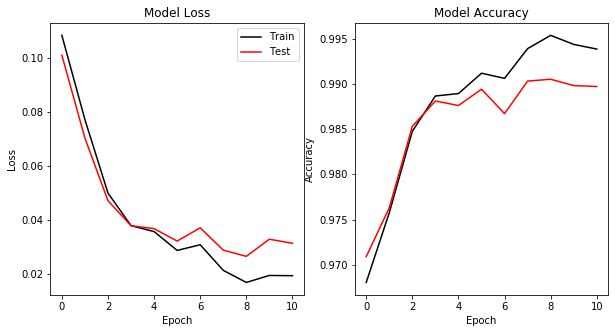

In [96]:
def plt_model_loss(history):
    """Generate plot for model loss and accuracy from training history
    Args:
        history ([type]): [description] 
    """
    # save_opt = get_varargin(kwargs, 'save', False)
    # figname = get_varargin(kwargs, 'figname', '{}-model_loss.png'.format(todaystr))
     
    fig = plt.figure(figsize = (10,5))
    # Loss 
    ax = fig.add_subplot(121)
    plt.plot(history['loss'], color = 'k' ) # Training
    plt.plot(history['val_loss'], color = 'r') # Validation
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    # Accuracy
    ax = fig.add_subplot(122)
    plt.plot(history['acc'], color = 'k')
    plt.plot(history['val_acc'], color = 'r')
    # Annotation
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
history = loadHistory(config.PATH.HISTORY_FILE)
plt_model_loss(history)

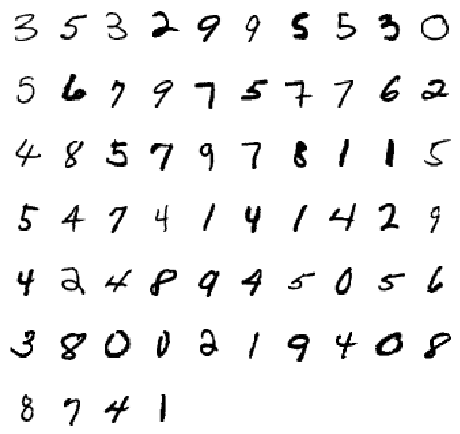

In [105]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
nb_images = images.shape[0]
figure = plt.figure(figsize = (8,8))
nb_cols = 10
nb_rows = np.ceil(nb_images/nb_cols)
for idx in range(nb_images):
    plt.subplot(nb_rows, nb_cols, idx+1)
    plt.axis('off')
    plt.imshow(images[idx].numpy().squeeze(), cmap='gray_r')

20190926-03:25 | <ipython-input-87-b017201b74c0> - INFO - Load checkpoint from: dnn_project\logs\DNN_model-checkpoint-best.pth.tar
20190926-03:25 | <ipython-input-87-b017201b74c0> - INFO - DONE: load_checkpoint.	Elapsed Time: 10.00ms	
0.921875


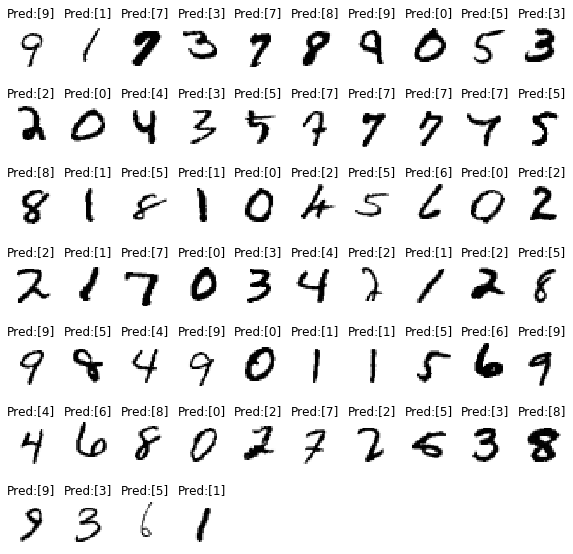

In [128]:
model = Net().to(config.HARDWARE.DEVICE)
optimizer = optim.SGD(model.parameters(), lr = config.TRAIN.LR, momentum = config.TRAIN.MOMENTUM)
ckpts_dict = load_checkpoint()
model.load_state_dict(ckpts_dict['model_state_dict'])
optimizer.load_state_dict(ckpts_dict['optimizer_state_dict'])
images, target = next(iter(test_loader))
model.eval()
acc = 0
with torch.no_grad():
    outputs = model(images.to(config.HARDWARE.DEVICE))
    preds = outputs.argmax(dim=1, keepdim = True)
    acc += preds.eq(target.to(config.HARDWARE.DEVICE).view_as(preds)).sum().item()

nb_images = images.shape[0]
print(acc/nb_images)
figure = plt.figure(figsize = (10,10))
nb_cols = 10
nb_rows = np.ceil(nb_images/nb_cols)
for idx, (img, pred) in enumerate(zip(images,preds)):
    plt.subplot(nb_rows, nb_cols, idx+1)
    plt.axis('off')
    plt.imshow(img.numpy().squeeze(), cmap='gray_r')
    plt.title('Pred:{}'.format(pred.cpu().numpy()))

Test Accuray: 0.9481. Numbers of Prediction: 10000


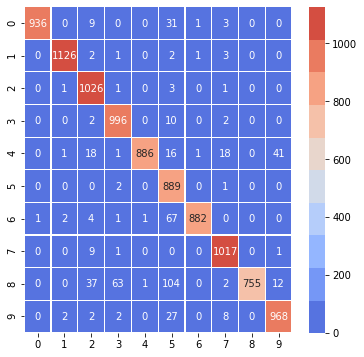

In [146]:
def plt_confusion_matrix(predicts, targets, **kwargs):
    """Plot confusion matrix for Y_label vs Y_predict
    
    Args:
        Y_label ([type]): Data label
        Y_predict ([type]): Prediction from model
    """
    save_opt = get_varargin(kwargs, 'save', False)
    figname = get_varargin(kwargs, 'figname', '{}-model_loss.png'.format(todaystr))

    fig = plt.figure(figsize = (6,6))
    cm = confusion_matrix(y_true = targets, 
                        y_pred = predicts)
    sns.heatmap(cm, annot = True, linewidth = 0.2, 
                cmap = sns.color_palette("coolwarm", 10), fmt = 'd')


val_loader = torch.utils.data.DataLoader(testset, batch_size = len(testset), shuffle = True)
images, labels = next(iter(val_loader))
model.eval()
acc = 0
with torch.no_grad():
    outputs = model(images.to(config.HARDWARE.DEVICE))
    preds = outputs.argmax(dim=1, keepdim = True).cpu().numpy().flatten()
labels = labels.cpu().numpy().flatten()
acc = np.sum(preds == labels)/len(labels)
print('Test Accuray: {}. Numbers of Prediction: {}'.format(acc, len(labels)))
plt_confusion_matrix(preds, labels)